In [1]:
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('model_data.csv')

In [3]:
Booked = (sum(df['BOOK_APPT_EVENT_SESSION'])/len(df['BOOK_APPT_EVENT_SESSION'].index))*100
Booked

10.319319710182654

In [4]:
X = df.drop(['BOOK_APPT_EVENT_SESSION', 'CHANNEL_GROUPING', 'HOUR', 'HOUR_BIN', 'TRAFFIC_SOURCE_SOURCE', 'TRAFFIC_SOURCE_MEDIUM', '3_0', 'BLOG_BUYCARS_SESSION', '2_0', '1_0'], axis=1)
y = df['BOOK_APPT_EVENT_SESSION']
columns_ = X.columns

In [5]:
y.value_counts()

0.0    41341
1.0     4757
Name: BOOK_APPT_EVENT_SESSION, dtype: int64

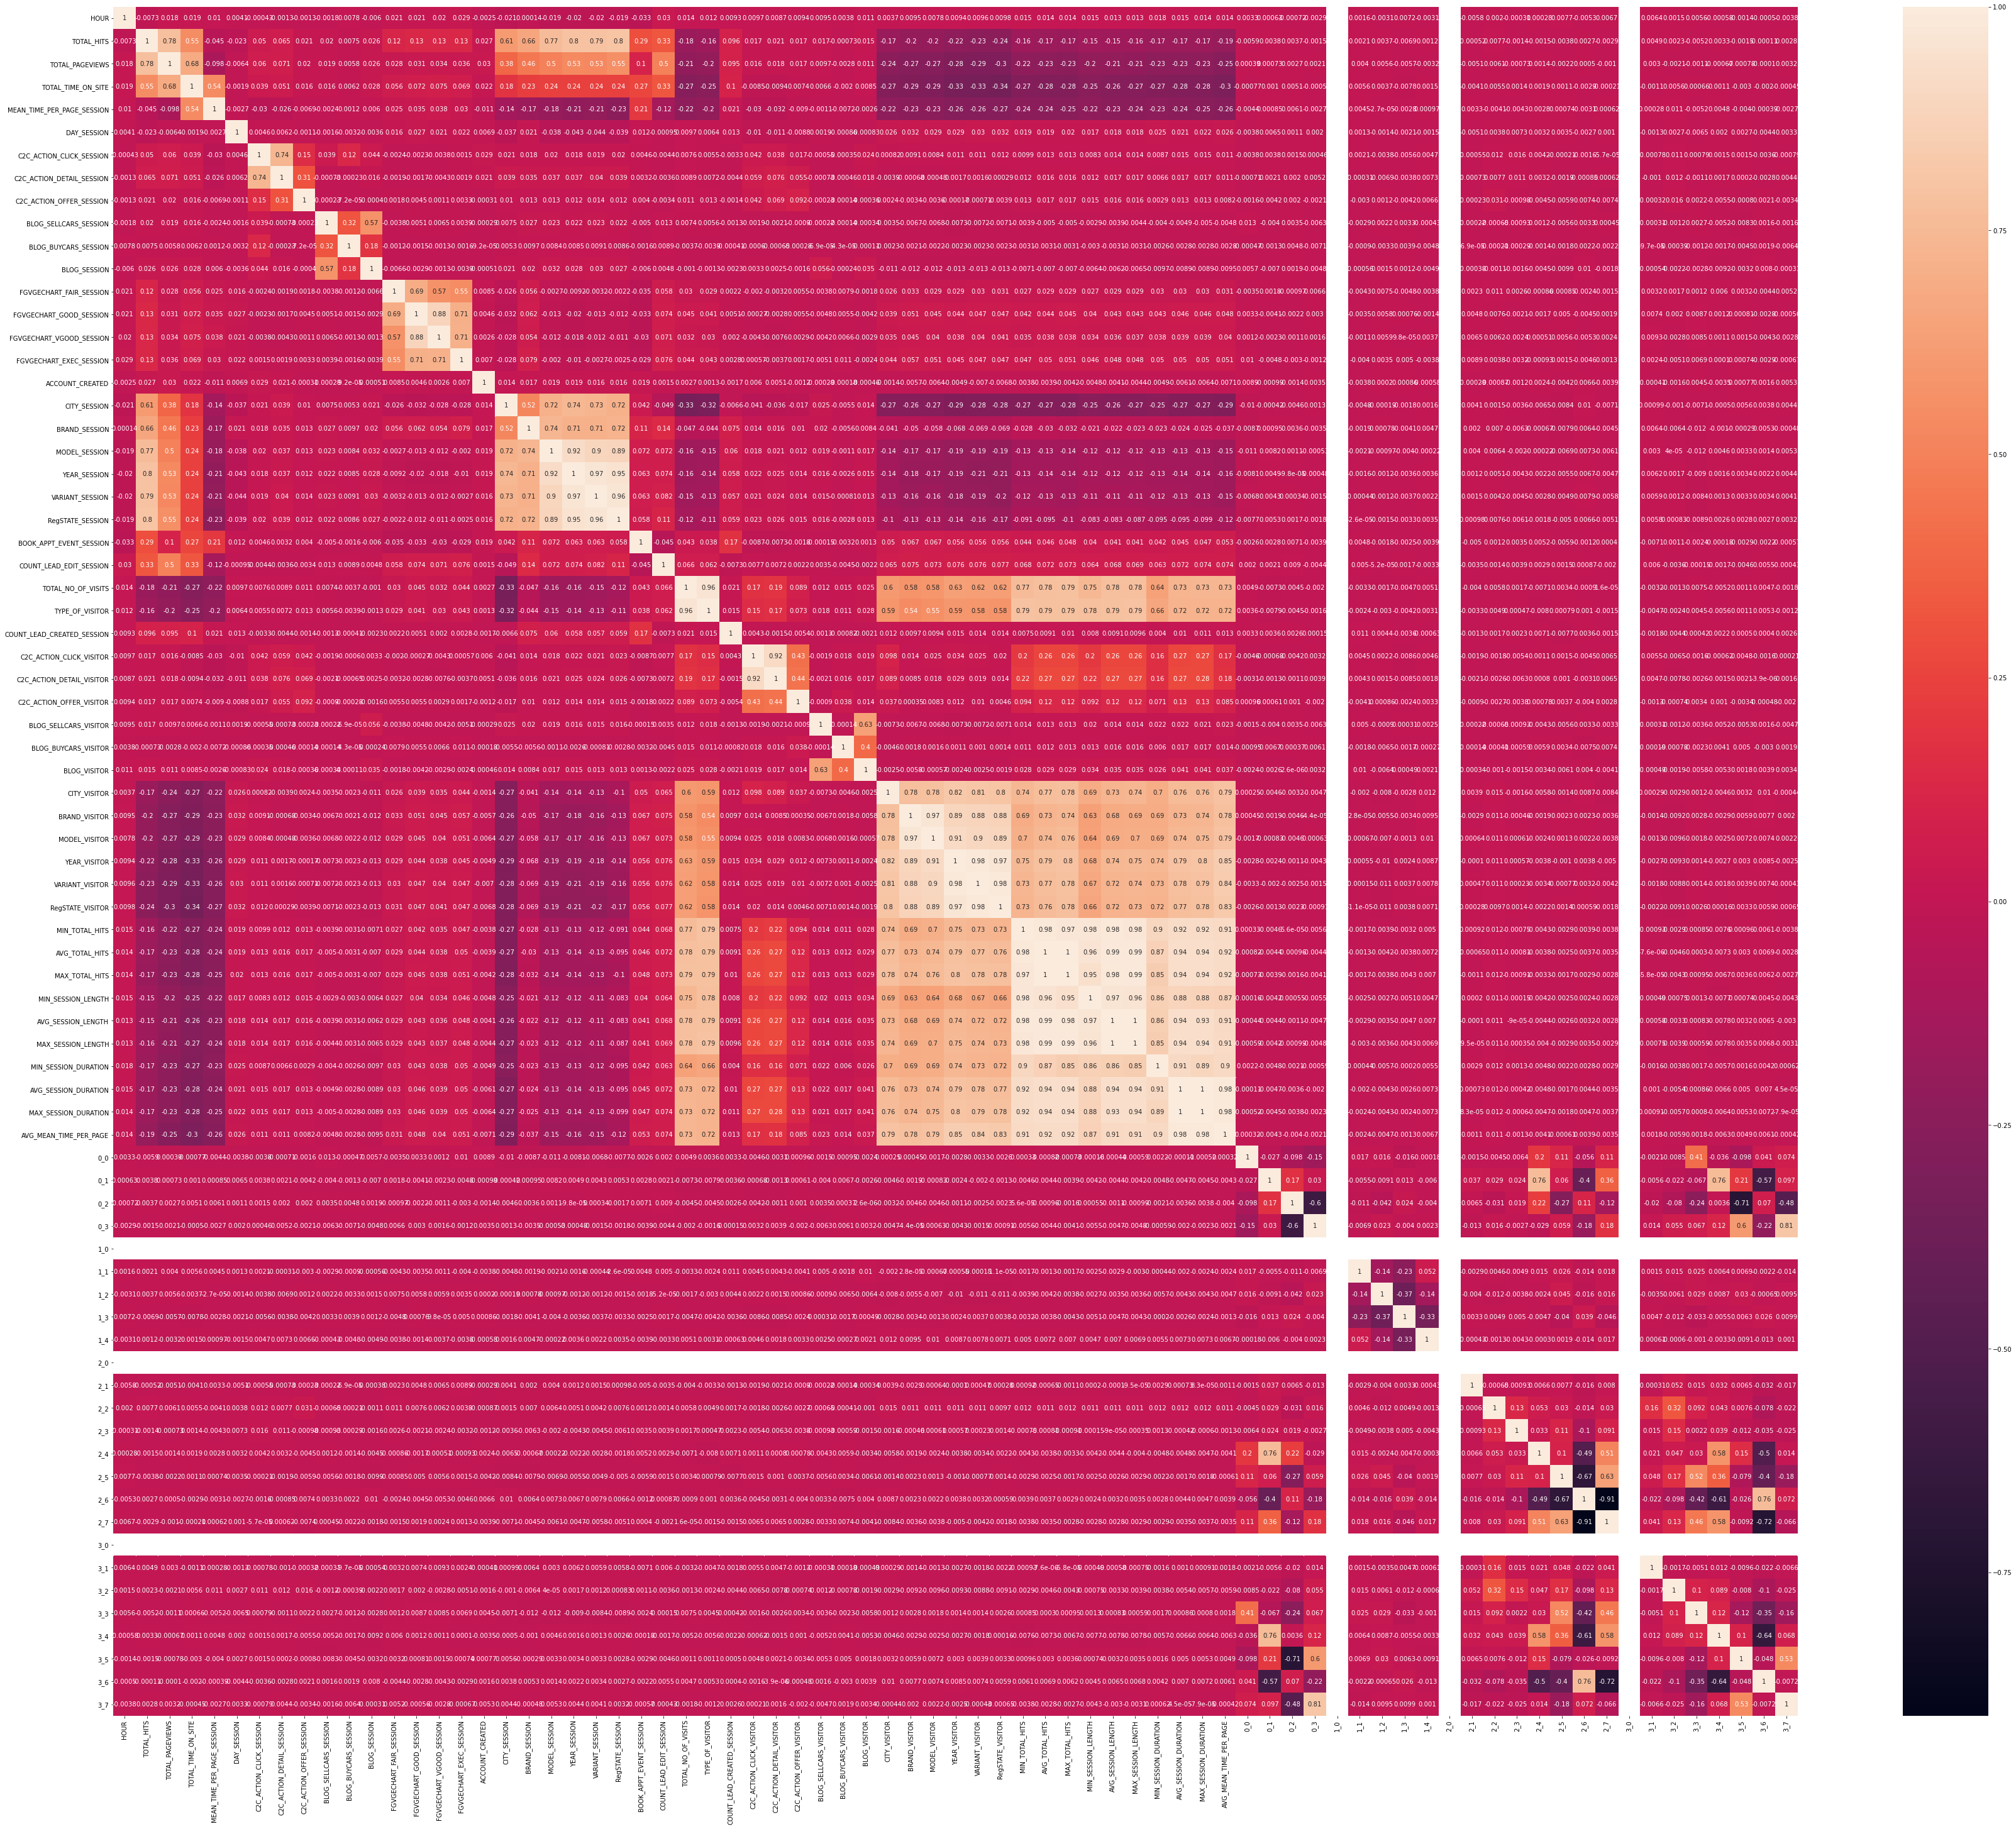

In [6]:
plt.figure(figsize = (60,50));
sns.heatmap(df.corr('spearman'), annot = True);

In [7]:
corr = df.corr()
print (corr['BOOK_APPT_EVENT_SESSION'].sort_values(ascending = False)[:30], '\n') #top 20 values

BOOK_APPT_EVENT_SESSION       1.000000
TOTAL_TIME_ON_SITE            0.289076
TOTAL_HITS                    0.287991
MEAN_TIME_PER_PAGE_SESSION    0.205888
COUNT_LEAD_CREATED_SESSION    0.142069
TOTAL_PAGEVIEWS               0.074830
BRAND_SESSION                 0.068537
BRAND_VISITOR                 0.058283
MODEL_VISITOR                 0.056982
VARIANT_VISITOR               0.052311
RegSTATE_VISITOR              0.051494
CITY_VISITOR                  0.050560
YEAR_VISITOR                  0.049270
CITY_SESSION                  0.041925
VARIANT_SESSION               0.041652
TOTAL_NO_OF_VISITS            0.041033
RegSTATE_SESSION              0.038439
TYPE_OF_VISITOR               0.038255
AVG_MEAN_TIME_PER_PAGE        0.037136
YEAR_SESSION                  0.036490
MODEL_SESSION                 0.034771
ACCOUNT_CREATED               0.018561
MAX_SESSION_DURATION          0.011640
MAX_TOTAL_HITS                0.010105
AVG_SESSION_DURATION          0.009799
DAY_SESSION              

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn import metrics

In [9]:
oversample = SMOTE()
train, test, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)
train, ytrain = oversample.fit_resample(train, ytrain)
train.shape, test.shape

((66158, 69), (9220, 69))

In [10]:
pipelines = []
pipelines.append(('LR', Pipeline([('LR',LogisticRegression())])))
pipelines.append(('KNN', Pipeline([('KNN', KNeighborsClassifier())])))
pipelines.append(('CART', Pipeline([('CART', DecisionTreeClassifier())])))
pipelines.append(('RF', Pipeline([('RF', RandomForestClassifier())])))
pipelines.append(('GBM', Pipeline([('RF', GradientBoostingClassifier())])))
pipelines.append(('XGB', Pipeline([('XGB', xgb.XGBClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = 10, random_state = 21)
    cv_results = cross_val_score(model, train, ytrain, cv = kfold, scoring = 'neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.071057 (0.005697)
KNN: -0.067836 (0.052252)
CART: -0.035037 (0.018135)
RF: -0.017926 (0.014115)
GBM: -0.036911 (0.012314)
XGB: -0.036548 (0.013158)


In [10]:
clf = RandomForestClassifier()
clf.fit(train,ytrain)

y_pred = clf.predict(test)

In [11]:
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Accuracy: 0.9613882863340564


In [12]:
from sklearn.metrics import classification_report

print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      8262
         1.0       0.88      0.72      0.80       958

    accuracy                           0.96      9220
   macro avg       0.93      0.86      0.89      9220
weighted avg       0.96      0.96      0.96      9220



AUC: 0.97


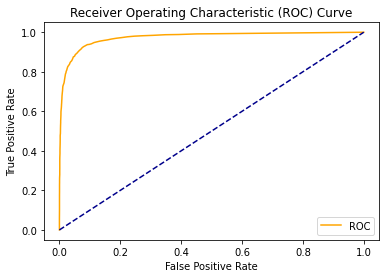

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

probs = clf.predict_proba(test)
prob = probs[:, 1]

auc = roc_auc_score(ytest, prob)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(ytest, prob)
plot_roc_curve(fpr, tpr)

In [14]:
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss

logloss = log_loss(ytest, prob)
brierloss = brier_score_loss(ytest, prob)
print(logloss, brierloss)

0.14337766664716 0.03376973869607135


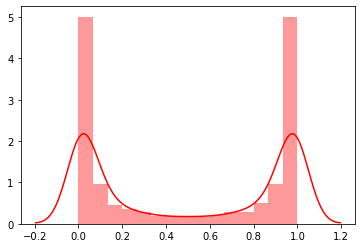

In [15]:
sns.distplot(probs, hist=True, color = 'red');

In [16]:
p = pd.DataFrame(prob)
p = p.rename(columns = {0: "prob"})
# different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    p[i] = p["prob"].map(lambda x: 1 if x > i else 0)
p.head()

,prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0,0,0,0,0,0,0,0,0,0
1,0.20,1,1,0,0,0,0,0,0,0,0
2,0.83,1,1,1,1,1,1,1,1,1,0
3,0.00,0,0,0,0,0,0,0,0,0,0
4,0.01,1,0,0,0,0,0,0,0,0,0


In [17]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(ytest, p[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity_recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity_recall,specificity]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.411605  0.994781  0.343985
0.1   0.1  0.829067  0.969729  0.812757
0.2   0.2  0.917245  0.931106  0.915638
0.3   0.3  0.947614  0.862213  0.957516
0.4   0.4  0.959544  0.802714  0.977729
0.5   0.5  0.961388  0.724426  0.988865
0.6   0.6  0.954555  0.616910  0.993706
0.7   0.7  0.943926  0.488518  0.996732
0.8   0.8  0.930911  0.345511  0.998790
0.9   0.9  0.915618  0.191023  0.999637


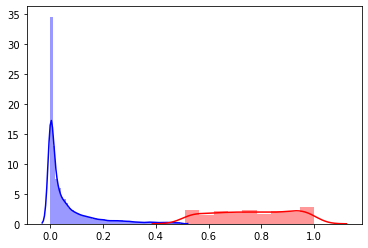

In [18]:
p = pd.DataFrame(prob)
z = p[p[0] < 0.5]
o = p[p[0] > 0.5]

sns.distplot(z, hist = True, color = 'blue');
sns.distplot(o, hist = True, color = 'red');

In [19]:
Prob = pd.DataFrame(probs)
Prob

,0,1
0,1.00,0.00
1,0.80,0.20
2,0.17,0.83
3,1.00,0.00
4,0.99,0.01
...,...,...
9215,0.97,0.03
9216,1.00,0.00
9217,0.86,0.14
9218,1.00,0.00


In [20]:
pr = pd.DataFrame(prob)
ytest = ytest.reset_index()
pr['actual'] = ytest['BOOK_APPT_EVENT_SESSION']
pr

,0,actual
0,0.00,0.0
1,0.20,0.0
2,0.83,1.0
3,0.00,0.0
4,0.01,0.0
...,...,...
9215,0.03,0.0
9216,0.00,0.0
9217,0.14,0.0
9218,0.00,0.0


In [21]:
zpr = pr[pr[0] < 0.5]
print(sum(zpr[0])/len(zpr), sum(zpr['actual'])/len(zpr)) 

0.06283543151227086 0.030641330166270783


In [22]:
opr = pr[pr[0] > 0.5]
print(sum(opr[0])/len(opr), sum(opr['actual'])/len(opr)) 

0.7655470737913487 0.8829516539440203


In [23]:
error = ytest['BOOK_APPT_EVENT_SESSION'] - y_pred
print(sum(error), sum(error)/len(ytest))

172.0 0.018655097613882864


In [24]:
# binomial confidence interval
from math import sqrt
interval = 1.96 * sqrt( (0.0052 * (1 - 0.0052)) / len(ytest))
print('%.3f' % interval)

0.001


In [25]:
feature_imp = pd.Series(clf.feature_importances_, index = columns_).sort_values(ascending = False)

In [26]:
feature_imp

TOTAL_HITS                    0.291923
TOTAL_TIME_ON_SITE            0.095751
MEAN_TIME_PER_PAGE_SESSION    0.091565
TOTAL_PAGEVIEWS               0.072841
COUNT_LEAD_EDIT_SESSION       0.041149
                                ...   
BLOG_SELLCARS_VISITOR         0.000020
3_1                           0.000003
2_1                           0.000002
BLOG_BUYCARS_VISITOR          0.000000
BLOG_SELLCARS_SESSION         0.000000
Length: 69, dtype: float64

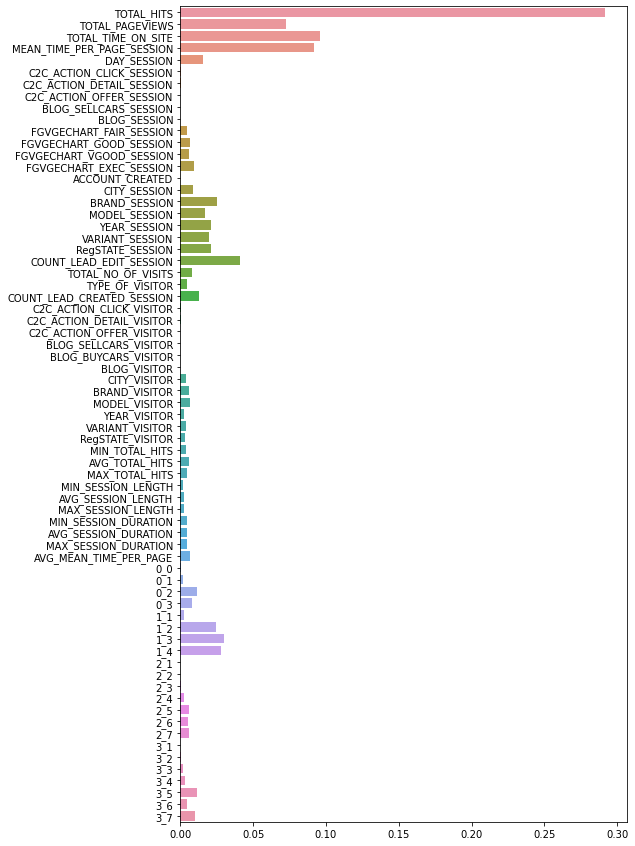

In [27]:
fig = plt.figure(figsize=(8,15))
sns.barplot(clf.feature_importances_, columns_)

In [28]:
pr = pr.sort_values(by = [0], ascending = False)
pr['pred'] = np.where(pr[0] > 0.5, 1, 0)
pr.head()

,0,actual,pred
8241,1.0,1.0,1
4373,1.0,1.0,1
7006,1.0,1.0,1
5013,1.0,1.0,1
5261,1.0,1.0,1


In [29]:
print(sum(pr['pred'])/len(pr), sum(pr['actual'])/len(pr))

0.08524945770065076 0.10390455531453362
